In [1]:
# sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Network
from tcn import TCN, compiled_tcn, tcn_full_summary
from keras_one_cycle_clr.keras_one_cycle_clr import CLR, OneCycle

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, model_from_json
print("Tensorflow - Número de GPUs encontradas: ", len(tf.config.experimental.list_physical_devices('GPU')) )

# utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sb



Tensorflow - Número de GPUs encontradas:  1


In [2]:
with open('features.pckl', 'rb') as f:
    X, y = pickle.load(f)


(3327, 40)


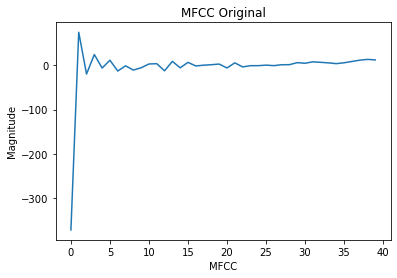

In [3]:
# Split between train and test 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)
print(x_train.shape)
plt.plot(x_train[9,:])
plt.title('MFCC Original')
plt.xlabel('MFCC')
plt.ylabel('Magnitude')
plt.show()

(3327, 40, 1)


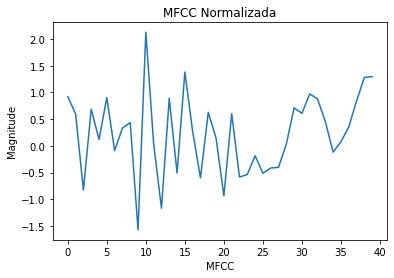

In [4]:
def scale_dataset(x_in, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(x_in, axis=0)
        std = np.std(x_in, axis=0)
    y_out = (x_in - mean)/std
    return y_out, mean, std

x_train, mean_in, std_in = scale_dataset(x_train)
x_test = scale_dataset(x_test, mean_in, std_in)[0]

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# save for  inference
with open('Network/input_preprocess.pckl', 'wb') as f:
    pickle.dump([mean_in, std_in], f)

    
print(x_train.shape)
plt.plot(x_train[9,:])
plt.title('MFCC Normalizada')
plt.xlabel('MFCC')
plt.ylabel('Magnitude')
plt.show()



In [5]:
batch_size = 16
epochs = 15
clr = CLR(cyc=2,
            lr_range=(0.01, 0.00005),
            momentum_range=(0.85, 0.98),
            record_frq=10)

# clr.test_run(epochs)
# plt.savefig("Network/LR_schedule.pdf", bbox_inches='tight')

In [11]:
model = compiled_tcn(return_sequences=False,
                    num_feat=x_train.shape[2],
                    num_classes=7,
                    nb_filters=64,
                    kernel_size=8,
                    dilations=[2 ** i for i in range(8)], 
                    nb_stacks=1,
                    dropout_rate=0.2,
                    use_batch_norm=True,
                    max_len=x_train[0:1].shape[1],
                    use_skip_connections=True,
                    use_layer_norm=True,
                    opt='adam')
model.summary()
cnnhistory = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        validation_data=(x_test, y_test),
                        epochs = epochs)



x.shape= (None, 64)
model.x = (None, 40, 1)
model.y = (None, 7)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 1)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                497280    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
_________________________________________________________________
activation_1 (Activation)    (None, 7)                 0         
Total params: 497,735
Trainable params: 495,687
Non-trainable params: 2,048
_________________________________________________________________
Epoch 1/15
208/208 [==============================] - 30s 145ms/step - loss: 1.4169 - accuracy: 0.6005 - val_loss: 1.0173 - val_accuracy: 0.6779
Epoch 2/15
208/208 [=============

In [12]:
# get model as json string and save to file
model_as_json = model.to_json()
with open('Network/model.json', "w") as json_file:
    json_file.write(model_as_json)
# save weights to file (for this format, need h5py installed)
model.save_weights('Network/weights.h5')



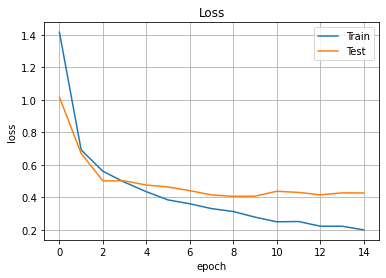

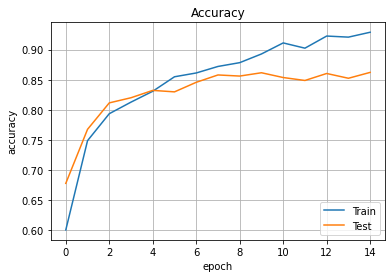

In [13]:
h = plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid()
plt.show()
h.savefig("Network/Loss.pdf", bbox_inches='tight')


h = plt.figure()
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid()
plt.show()
h.savefig("Network/Accuracy.pdf", bbox_inches='tight')



In [9]:
# load model from file
loaded_json = open('Network/model.json', 'r').read()
reloaded_model = model_from_json(loaded_json, custom_objects={'TCN': TCN})

# restore weights
reloaded_model.load_weights('Network/weights.h5')



52/52 [==============================] - 2s 37ms/step


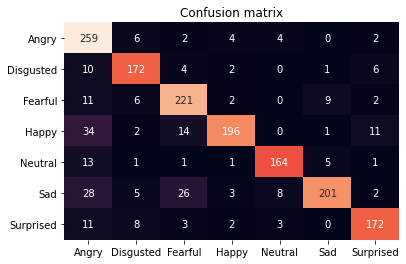

In [10]:
lb = LabelEncoder()
pred = np.round(reloaded_model.predict(x_test, verbose=1))
pred = pred.squeeze().argmax(axis=1)
new_y_test = y_test.astype(int)

mtx = confusion_matrix(new_y_test, pred)
labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
h = plt.figure()
sb.heatmap(mtx, annot = True, fmt ='d',
           yticklabels=labels,
           xticklabels=labels,
           cbar=False)
plt.title('Confusion matrix')
h.savefig("Network/Confusion.pdf", bbox_inches='tight')

